## Credit score and Loan optimization 

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

In [2]:
df = pd.read_csv("../data/processed/final-data.csv")

In [3]:
df

,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult,TotalTransactionAmount,AvgTransactionAmount,TransactionCount,StdTransactionAmount,TransactionHour,...,ProductCategory_utility_bill,ChannelId_ChannelId_1,ChannelId_ChannelId_2,ChannelId_ChannelId_3,ChannelId_ChannelId_5,TransactionId_numeric,BatchId_numeric,AccountId_numeric,SubscriptionId_numeric,CustomerId_numeric
0,-0.046371,-0.072291,2018-11-15 02:18:49+00:00,2,0,0.170118,-0.067623,-0.311831,-0.167922,2,...,0,0,0,1,0,76871.0,36123.0,3957.0,887.0,4406.0
1,-0.054643,-0.080251,2018-11-15 02:19:08+00:00,2,0,0.170118,-0.067623,-0.311831,-0.167922,2,...,0,0,1,0,0,73770.0,15642.0,4841.0,3829.0,4406.0
2,-0.050426,-0.076352,2018-11-15 02:44:21+00:00,2,0,0.165122,-0.072568,-0.444993,-0.201992,2,...,0,0,0,1,0,26203.0,53941.0,4229.0,222.0,4683.0
3,0.107717,0.096648,2018-11-15 03:32:55+00:00,2,0,0.175567,-0.008155,-0.404020,-0.009717,3,...,1,0,0,1,0,380.0,102363.0,648.0,2185.0,988.0
4,-0.059704,-0.075183,2018-11-15 03:34:21+00:00,2,0,0.175567,-0.008155,-0.404020,-0.009717,3,...,0,0,1,0,0,28195.0,38780.0,4841.0,3829.0,988.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95657,-0.062591,-0.072291,2019-02-13 09:54:09+00:00,2,0,0.276904,-0.028743,0.204885,0.050586,9,...,0,0,1,0,0,89881.0,96668.0,4841.0,3829.0,3078.0
95658,-0.046371,-0.072291,2019-02-13 09:54:25+00:00,2,0,0.167759,-0.062526,-0.398330,-0.176518,9,...,0,0,0,1,0,91597.0,3503.0,3439.0,2643.0,3874.0
95659,-0.054643,-0.080251,2019-02-13 09:54:35+00:00,2,0,0.167759,-0.062526,-0.398330,-0.176518,9,...,0,0,1,0,0,82501.0,118602.0,4841.0,3829.0,3874.0
95660,-0.030151,-0.056047,2019-02-13 10:01:10+00:00,2,0,0.204153,-0.059427,0.149116,-0.166068,10,...,0,0,0,1,0,136354.0,70924.0,1346.0,652.0,1709.0


## Number of Transactions per Day

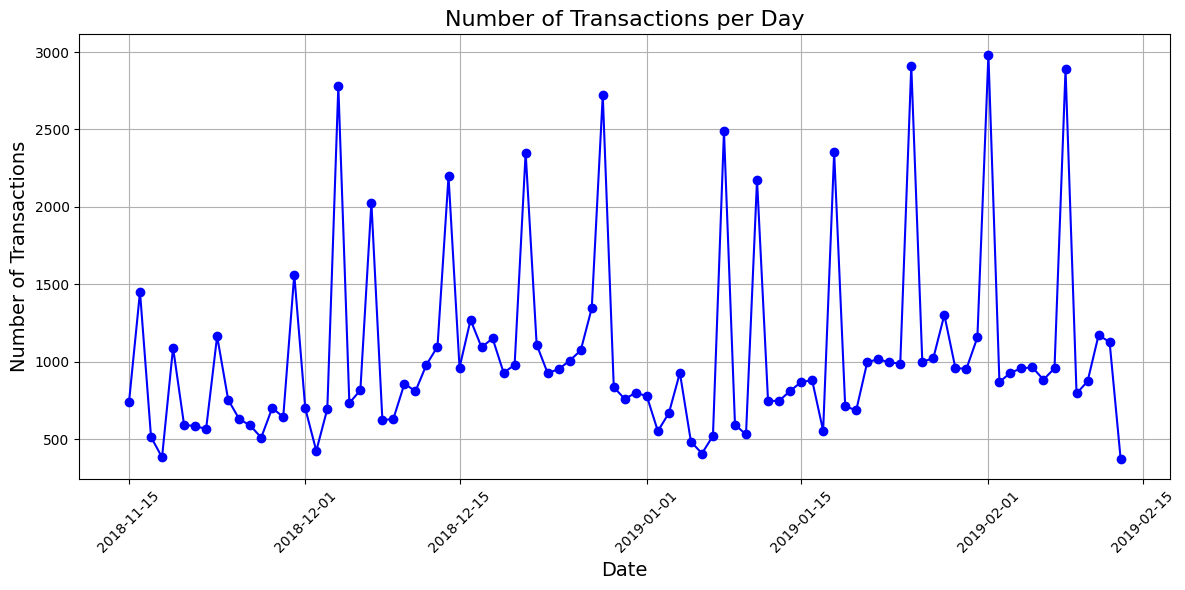

In [4]:
import matplotlib.pyplot as plt

# Ensure TransactionStartTime is in datetime format
df['TransactionStartTime'] = pd.to_datetime(df['TransactionStartTime'])

# Aggregate the data by date to count the number of transactions per day
daily_transactions = df.groupby(df['TransactionStartTime'].dt.date).size()

# Plot the number of transactions per day
plt.figure(figsize=(12, 6))
plt.plot(daily_transactions.index, daily_transactions.values, marker='o', linestyle='-', color='b')

# Add title and labels
plt.title('Number of Transactions per Day', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Number of Transactions', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True)

# Display the plot
plt.tight_layout()
plt.show()

## Calculating Recency, Frequency and Monetary

In [5]:
# Ensure TransactionStartTime is in datetime format and make it timezone-naive
df['TransactionStartTime'] = pd.to_datetime(df['TransactionStartTime']).dt.tz_localize(None)

# Step 1: Recency
# Define the reference date (timezone-naive)
reference_date = datetime(2019, 1, 1)  # Example reference date

# Calculate Recency (days since the last transaction for each customer)
recency_df = df.groupby('CustomerId_numeric').agg(
    Recency=('TransactionStartTime', lambda x: (reference_date - x.max()).days)
).reset_index()

# Step 2: Frequency
# Count the number of transactions per customer (Frequency)
frequency_df = df.groupby('CustomerId_numeric').agg(
    Frequency=('TransactionId_numeric', 'count')
).reset_index()

# Step 3: Monetary
# Sum the total transaction amount per customer (Monetary)
monetary_df = df.groupby('CustomerId_numeric').agg(
    Monetary=('Amount', 'sum')
).reset_index()

# Merge the Recency, Frequency, and Monetary dataframes
rfm_df = recency_df.merge(frequency_df, on='CustomerId_numeric')
rfm_df = rfm_df.merge(monetary_df, on='CustomerId_numeric')

# Step 4: Assign RFM Scores
# Use quantiles to assign scores to each component
rfm_df['R_Score'] = pd.qcut(rfm_df['Recency'], 4, labels=[4, 3, 2, 1])
rfm_df['F_Score'] = pd.qcut(rfm_df['Frequency'], 4, labels=[1, 2, 3, 4])
rfm_df['M_Score'] = pd.qcut(rfm_df['Monetary'], 4, labels=[1, 2, 3, 4])

# Step 5: Calculate total RFM score
rfm_df['RFM_Score'] = rfm_df[['R_Score', 'F_Score', 'M_Score']].sum(axis=1)

# Step 6: Classify Customers
# Define RFM Score threshold for classification (e.g., >= 8 is good, below is bad)
rfm_df['Risk_Category'] = np.where(rfm_df['RFM_Score'] >= 8, 'Good', 'Bad')

# Final output: Display Customer ID, RFM Score, and Risk Category
rfm_df[['CustomerId_numeric', 'RFM_Score', 'Risk_Category']]

,CustomerId_numeric,RFM_Score,Risk_Category
0,1.0,5,Bad
1,2.0,5,Bad
2,3.0,5,Bad
3,4.0,5,Bad
4,5.0,5,Bad
...,...,...,...
3737,7475.0,6,Bad
3738,7476.0,7,Bad
3739,7477.0,5,Bad
3740,7478.0,7,Bad


In [6]:
# Merge the original df with rfm_df on 'CustomerId_numeric'
df = df.merge(rfm_df[['CustomerId_numeric', 'RFM_Score', 'Risk_Category']], 
              on='CustomerId_numeric', 
              how='left')

# Now df will have the RFM_Score and Risk_Category columns added to it
df


,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult,TotalTransactionAmount,AvgTransactionAmount,TransactionCount,StdTransactionAmount,TransactionHour,...,ChannelId_ChannelId_2,ChannelId_ChannelId_3,ChannelId_ChannelId_5,TransactionId_numeric,BatchId_numeric,AccountId_numeric,SubscriptionId_numeric,CustomerId_numeric,RFM_Score,Risk_Category
0,-0.046371,-0.072291,2018-11-15 02:18:49,2,0,0.170118,-0.067623,-0.311831,-0.167922,2,...,0,1,0,76871.0,36123.0,3957.0,887.0,4406.0,9,Good
1,-0.054643,-0.080251,2018-11-15 02:19:08,2,0,0.170118,-0.067623,-0.311831,-0.167922,2,...,1,0,0,73770.0,15642.0,4841.0,3829.0,4406.0,9,Good
2,-0.050426,-0.076352,2018-11-15 02:44:21,2,0,0.165122,-0.072568,-0.444993,-0.201992,2,...,0,1,0,26203.0,53941.0,4229.0,222.0,4683.0,5,Bad
3,0.107717,0.096648,2018-11-15 03:32:55,2,0,0.175567,-0.008155,-0.404020,-0.009717,3,...,0,1,0,380.0,102363.0,648.0,2185.0,988.0,10,Good
4,-0.059704,-0.075183,2018-11-15 03:34:21,2,0,0.175567,-0.008155,-0.404020,-0.009717,3,...,1,0,0,28195.0,38780.0,4841.0,3829.0,988.0,10,Good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95657,-0.062591,-0.072291,2019-02-13 09:54:09,2,0,0.276904,-0.028743,0.204885,0.050586,9,...,1,0,0,89881.0,96668.0,4841.0,3829.0,3078.0,9,Good
95658,-0.046371,-0.072291,2019-02-13 09:54:25,2,0,0.167759,-0.062526,-0.398330,-0.176518,9,...,0,1,0,91597.0,3503.0,3439.0,2643.0,3874.0,9,Good
95659,-0.054643,-0.080251,2019-02-13 09:54:35,2,0,0.167759,-0.062526,-0.398330,-0.176518,9,...,1,0,0,82501.0,118602.0,4841.0,3829.0,3874.0,9,Good
95660,-0.030151,-0.056047,2019-02-13 10:01:10,2,0,0.204153,-0.059427,0.149116,-0.166068,10,...,0,1,0,136354.0,70924.0,1346.0,652.0,1709.0,9,Good


## Distribution of Risk Categories

C:\Users\1221\AppData\Local\Temp\ipykernel_13464\40262902.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=risk_counts.index, y=risk_counts.values, palette=custom_colors)


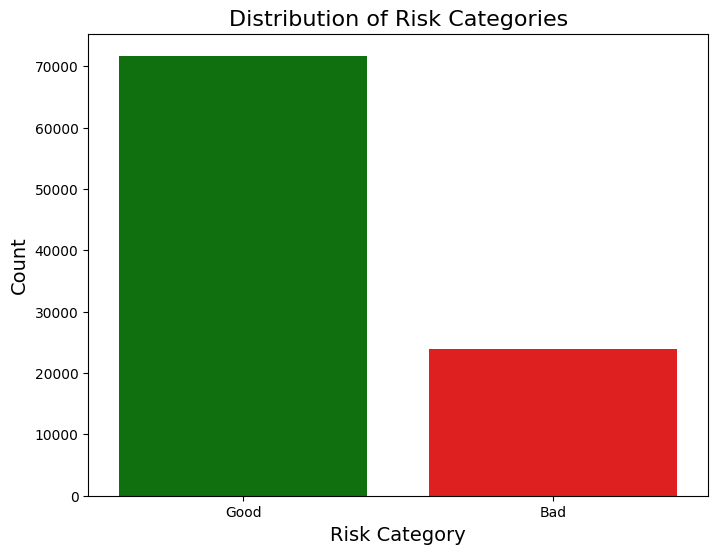

In [7]:
import seaborn as sns

# Count the occurrences of each Risk_Category
risk_counts = df['Risk_Category'].value_counts()

# Define custom colors for "Good" and "Bad"
custom_colors = ['red' if category == 'Bad' else 'green' for category in risk_counts.index]

# Create the barplot
plt.figure(figsize=(8, 6))
sns.barplot(x=risk_counts.index, y=risk_counts.values, palette=custom_colors)

# Add labels and title
plt.title('Distribution of Risk Categories', fontsize=16)
plt.xlabel('Risk Category', fontsize=14)
plt.ylabel('Count', fontsize=14)

# Display the plot
plt.show()

## Loan Amount Optimization

In [8]:
# Loan allocation function
def loan_amount_optimization(row):
    # Define base loan amounts
    base_loan = 1000  # Base loan for "Bad" risk category
    
    
    if row['Risk_Category'] == 'Bad':
        # Lower loan for higher RFM_Score to manage risk
        return base_loan - (row['RFM_Score'] * 50)  # Adjust by RFM_Score
    else:
        # Higher loan for low-risk customers
        return base_loan + (row['RFM_Score'] * 200)

# Apply loan optimization
df['Optimized_Loan_Amount'] = df.apply(loan_amount_optimization, axis=1)

# Display the results
df


,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult,TotalTransactionAmount,AvgTransactionAmount,TransactionCount,StdTransactionAmount,TransactionHour,...,ChannelId_ChannelId_3,ChannelId_ChannelId_5,TransactionId_numeric,BatchId_numeric,AccountId_numeric,SubscriptionId_numeric,CustomerId_numeric,RFM_Score,Risk_Category,Optimized_Loan_Amount
0,-0.046371,-0.072291,2018-11-15 02:18:49,2,0,0.170118,-0.067623,-0.311831,-0.167922,2,...,1,0,76871.0,36123.0,3957.0,887.0,4406.0,9,Good,2800
1,-0.054643,-0.080251,2018-11-15 02:19:08,2,0,0.170118,-0.067623,-0.311831,-0.167922,2,...,0,0,73770.0,15642.0,4841.0,3829.0,4406.0,9,Good,2800
2,-0.050426,-0.076352,2018-11-15 02:44:21,2,0,0.165122,-0.072568,-0.444993,-0.201992,2,...,1,0,26203.0,53941.0,4229.0,222.0,4683.0,5,Bad,750
3,0.107717,0.096648,2018-11-15 03:32:55,2,0,0.175567,-0.008155,-0.404020,-0.009717,3,...,1,0,380.0,102363.0,648.0,2185.0,988.0,10,Good,3000
4,-0.059704,-0.075183,2018-11-15 03:34:21,2,0,0.175567,-0.008155,-0.404020,-0.009717,3,...,0,0,28195.0,38780.0,4841.0,3829.0,988.0,10,Good,3000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95657,-0.062591,-0.072291,2019-02-13 09:54:09,2,0,0.276904,-0.028743,0.204885,0.050586,9,...,0,0,89881.0,96668.0,4841.0,3829.0,3078.0,9,Good,2800
95658,-0.046371,-0.072291,2019-02-13 09:54:25,2,0,0.167759,-0.062526,-0.398330,-0.176518,9,...,1,0,91597.0,3503.0,3439.0,2643.0,3874.0,9,Good,2800
95659,-0.054643,-0.080251,2019-02-13 09:54:35,2,0,0.167759,-0.062526,-0.398330,-0.176518,9,...,0,0,82501.0,118602.0,4841.0,3829.0,3874.0,9,Good,2800
95660,-0.030151,-0.056047,2019-02-13 10:01:10,2,0,0.204153,-0.059427,0.149116,-0.166068,10,...,1,0,136354.0,70924.0,1346.0,652.0,1709.0,9,Good,2800


## Optimized Loan Amount per Customer

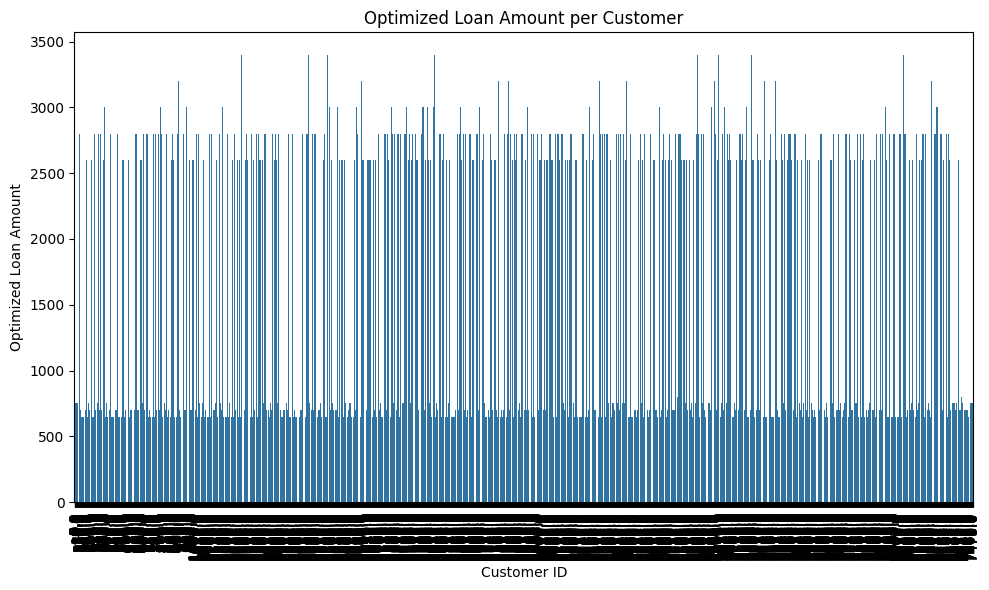

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the Optimized Loan Amount for each CustomerId_numeric
plt.figure(figsize=(10, 6))
sns.barplot(x='CustomerId_numeric', y='Optimized_Loan_Amount', data=df)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=90)

# Add labels and title
plt.xlabel('Customer ID')
plt.ylabel('Optimized Loan Amount')
plt.title('Optimized Loan Amount per Customer')

# Show the plot
plt.tight_layout()
plt.show()

## Optimized Loan Amount per Customer for selected Customers

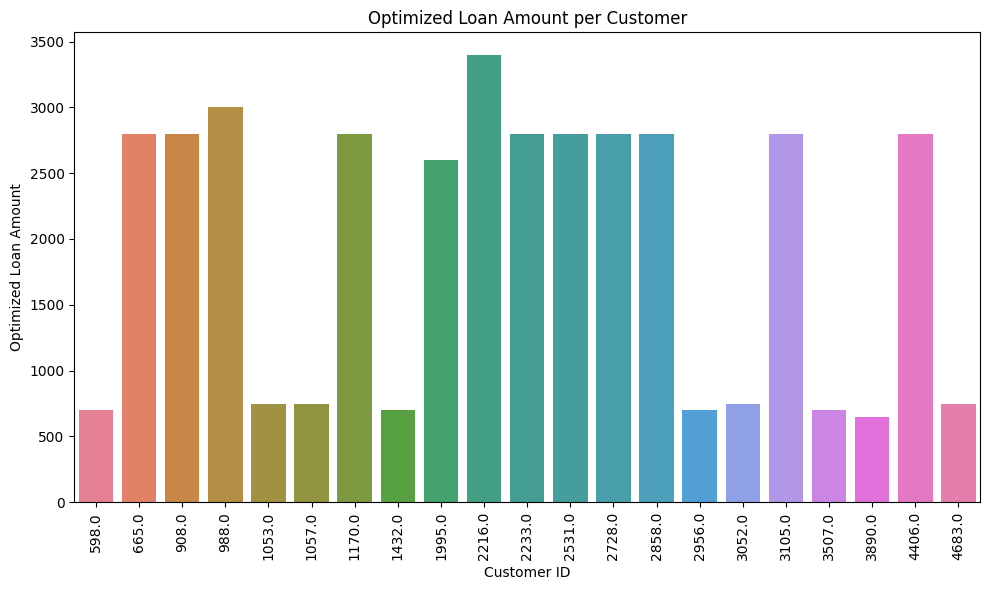

In [10]:
import seaborn as sns

# Limit the number of unique Customer IDs for better visualization 
df = df.head(50)  

# Set a color palette
palette = sns.color_palette("husl", len(df['CustomerId_numeric'].unique()))  # Match palette size with unique customers

# Plot the Optimized Loan Amount for each CustomerId_numeric
plt.figure(figsize=(10, 6))
sns.barplot(x='CustomerId_numeric', y='Optimized_Loan_Amount', data=df, hue='CustomerId_numeric', 
            palette=palette, dodge=False, legend=False)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=90)

# Add labels and title
plt.xlabel('Customer ID')
plt.ylabel('Optimized Loan Amount')
plt.title('Optimized Loan Amount per Customer')

# Show the plot
plt.tight_layout()
plt.show()
